In [1]:
import csv
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import itertools as it
import numpy.matlib as nm
from sklearn import metrics
import sklearn.model_selection as ms
import sklearn.metrics as metrics
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn import linear_model
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn 
from scipy.stats import poisson
import statsmodels.api as sm
from numpy import random as rn
from scipy import stats
from fitter import Fitter, get_common_distributions
from scipy.stats import weibull_max
from tqdm import tqdm
from scipy.integrate import quad
from ipywidgets import interact, FloatSlider, IntSlider
import scipy.interpolate as interp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
short_rates = pd.read_csv('short_rates.csv', sep=';', decimal=',')
short_rates[:2506]

,tradedate,tradetime,period_0.25
0,06.01.2014,12:21:16,5.92
1,08.01.2014,12:41:22,5.92
2,09.01.2014,18:38:19,5.78
3,10.01.2014,18:38:17,5.70
4,13.01.2014,18:37:26,5.81
...,...,...,...
2501,25.12.2023,18:39:59,13.78
2502,26.12.2023,18:39:59,13.33
2503,27.12.2023,18:39:57,13.22
2504,28.12.2023,18:39:57,12.78


Time interval: δt=0.08333333333333333 years
Simulation path M=1000000


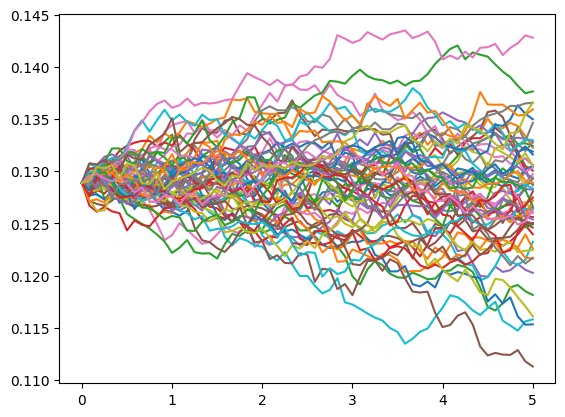

The expected value for the interest rate is: 12.770%
The standard error of sample mean is: 0.0006%
Lower 99% is: 12.768%
Upper 99% is: 12.771%


In [3]:
'''Parameters a, b, σ for Cox-Ingersoll-Ross colibrated in excel: CIR_Calibration.xlsx'''

a = 0.004924420
b = 0.079128172
σ = 0.007782762

r0 = 0.1289  # as of 03.01.2024
T = 5
N = 60
δt = T/N
print(f"Time interval: δt={δt} years")
M = 1000000
print(f"Simulation path M={M}")
dz = rn.randn(M,N)
r = r0*np.ones((M,N+1))
for i in range(0,N):
    r[:,i+1] = r[:,i] + a*(b-r[:,i])*δt + σ*np.sqrt(r[:,i])*dz[:,i]*np.sqrt(δt)
plt.show()

a = [ rn.randint(0,M) for j in range(1,60)]

for runer in a:
    plt.plot(np.arange(0,T+δt,δt),r[runer])
plt.show()
V = (r[:,-1])
print("The expected value for the interest rate is:","{:.3%}".format(np.mean(V)))
print("The standard error of sample mean is:", "{:.4%}".format(np.std(V)/np.sqrt(M)))
from scipy.stats import norm
def normsinv(x):
    x = norm.ppf(x)
    return (x)

z = normsinv(0.995)
μ = np.mean(V)
SE = np.std(V)/np.sqrt(M)

print("Lower 99% is:","{:.3%}".format( (μ-z*SE) ))
print("Upper 99% is:","{:.3%}".format( (μ+z*SE) ))

In [4]:
a = 0.004924420
b = 0.079128172
σ = 0.007782762

r0 = 0.1289  # as of 03.01.2024
T = 5
N = 60
δt = 0.08333333333333333
M = 1000000
dz = rn.randn(M,N)
r = r0*np.ones((M,N+1))

for i in range(0,N):
    r[:,i+1] = r[:,i] + a*(b-r[:,i])*δt + σ*np.sqrt(r[:,i])*dz[:,i]*np.sqrt(δt)

rate = []
years = []
for i in range(0,61):
    rate.append(np.mean(r[:,i]))
    years.append(i/12)

In [5]:
df = pd.read_excel(io='Data.xlsx',sheet_name='VFD', usecols = 'A:DK')
df.head(101)

,region,t_2003,n_2003,b_2003,d_2003,inj_2003,pr_2003,t_2004,n_2004,b_2004,...,b_2021,d_2021,inj_2021,pr_2021,t_2022,n_2022,b_2022,d_2022,inj_2022,pr_2022
0,Республика Башкортостан,4,1,0,5,3,0,13,0,0,...,7,15,34,2430.682,3,2,0,8,21,3.289630
1,Республика Марий-Эл,5,0,0,24,40,0,6,1,0,...,4,0,0,45.594,0,2,0,0,0,13.071356
2,Республика Мордовия,3,0,0,21,52,0,3,0,2,...,0,0,0,97.925,0,0,0,0,0,0.000000
3,Республика Татарстан,3,0,0,8,14,0,13,1,0,...,0,28,66,28064.600,0,0,0,0,0,0.000000
4,Удмуртская Республика,9,0,0,13,103,0,11,2,1,...,0,4,80,2.407,2,0,0,2,68,0.522862
5,Чувашская Республика,0,0,0,0,0,0,9,1,0,...,0,1,10,171.860,1,2,0,4,585,112.000000
6,Пермский край,17,0,0,21,10,0,20,2,0,...,3,5,5,625.352,1,0,0,0,0,9.500000
7,Кировская область,2,0,0,0,0,0,5,0,0,...,1,0,0,162.929,0,0,0,0,0,0.000000
8,Нижегородская область,52,0,0,20,195,0,23,0,0,...,6,6,257,407.055,5,2,0,2,62902,134.668788
9,Оренбургская область,5,2,0,9,56,0,13,1,1,...,0,0,0,2976.653,1,1,0,0,30,29.693312


In [6]:
df.describe()

,t_2003,n_2003,b_2003,d_2003,inj_2003,pr_2003,t_2004,n_2004,b_2004,d_2004,...,b_2021,d_2021,inj_2021,pr_2021,t_2022,n_2022,b_2022,d_2022,inj_2022,pr_2022
count,14.000000,14.000000,14.0,14.000000,14.000000,14.0,14.000000,14.0000,14.000000,14.000000,...,14.000000,14.000000,14.00000,14.000000,14.000000,14.000000,14.0,14.000000,14.000000,14.000000
mean,8.928571,0.428571,0.0,12.428571,44.428571,0.0,10.642857,1.0000,0.285714,25.928571,...,1.714286,6.214286,40.00000,2503.309000,1.500000,0.928571,0.0,2.428571,4593.500000,30.801111
std,13.094122,0.755929,0.0,8.907337,52.782156,0.0,6.476076,1.1094,0.611250,14.631180,...,2.367360,9.014335,68.27884,7417.673482,1.556624,1.071612,0.0,4.518582,16783.780636,47.827601
min,0.000000,0.000000,0.0,0.000000,0.000000,0.0,3.000000,0.0000,0.000000,8.000000,...,0.000000,0.000000,0.00000,0.722000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.0,6.000000,4.750000,0.0,5.250000,0.0000,0.000000,17.500000,...,0.000000,0.000000,0.00000,22.165000,0.250000,0.000000,0.0,0.000000,0.000000,0.000000
50%,5.000000,0.000000,0.0,11.000000,38.500000,0.0,10.000000,1.0000,0.000000,23.000000,...,1.000000,2.500000,10.00000,130.427000,1.000000,0.500000,0.0,0.000000,18.000000,6.394815
75%,8.500000,0.750000,0.0,20.750000,55.000000,0.0,13.000000,1.0000,0.000000,33.750000,...,2.500000,5.750000,50.50000,570.777750,2.000000,2.000000,0.0,2.000000,58.500000,28.754384
max,52.000000,2.000000,0.0,27.000000,195.000000,0.0,23.000000,4.0000,2.000000,58.000000,...,7.000000,28.000000,257.00000,28064.600000,5.000000,3.000000,0.0,16.000000,62902.000000,134.668788


In [8]:
'''Number of Technogenic and Natural in each year'''
t_n = []

t_n.append(sum(df["t_2022"]+df["n_2022"]))
t_n.append(sum(df["t_2021"]+df["n_2021"]))
t_n.append(sum(df["t_2020"]+df["n_2020"]))
t_n.append(sum(df["t_2019"]+df["n_2019"]))
t_n.append(sum(df["t_2018"]+df["n_2018"]))
t_n.append(sum(df["t_2017"]+df["n_2017"]))
t_n.append(sum(df["t_2016"]+df["n_2016"]))
t_n.append(sum(df["t_2015"]+df["n_2015"]))
t_n.append(sum(df["t_2014"]+df["n_2014"]))

'''Claim size'''

ips = [1.1091, 1.1163, 1.0464, 1.0190, 1.0419, 1.0273, 1.0527, 1.0861, 1.1193] # inflation in region 

pr = []

pr.append(sum(df["pr_2022"])*math.prod(ips[8:]))
pr.append(sum(df["pr_2021"])*math.prod(ips[7:]))
pr.append(sum(df["pr_2020"])*math.prod(ips[6:]))
pr.append(sum(df["pr_2019"])*math.prod(ips[5:]))
pr.append(sum(df["pr_2018"])*math.prod(ips[4:]))
pr.append(sum(df["pr_2017"])*math.prod(ips[3:]))
pr.append(sum(df["pr_2016"])*math.prod(ips[2:]))
pr.append(sum(df["pr_2015"])*math.prod(ips[1:]))
pr.append(sum(df["pr_2014"])*math.prod(ips))

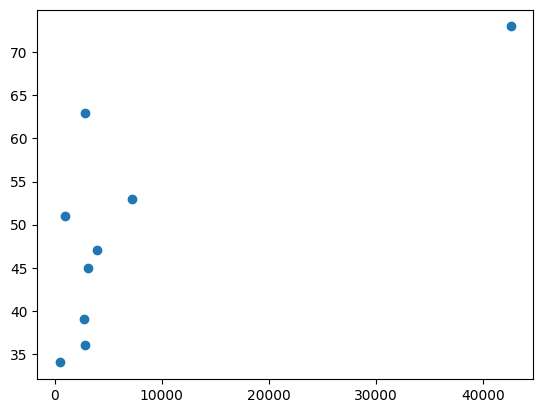

In [9]:
plt.scatter(pr, t_n)

In [10]:
np.mean(t_n)

49.0

In [11]:
'''average claim size for one disaster'''
one_pr = [int(p) / int(t) for p,t in zip(pr, t_n)]
print(one_pr)
np.mean(one_pr)

[14.176470588235293, 583.6164383561644, 18.686274509803923, 135.9056603773585, 69.8, 71.07692307692308, 44.58730158730159, 84.61702127659575, 77.58333333333333]


122.22771367841285

2024-05-10 02:51:08.642 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.003769)
2024-05-10 02:51:08.662 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.004502)
2024-05-10 02:51:08.693 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.003848)
2024-05-10 02:51:08.694 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.003436)
2024-05-10 02:51:08.696 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.00348)
2024-05-10 02:51:08.697 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.003711)
2024-05-10 02:51:08.698 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.004641)
2024-05-10 02:51:08.707 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted ra

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
chi2,0.003331,1575.910954,1576.502627,inf,0.373529,0.123404
exponweib,0.003409,1464.776847,1465.565745,inf,0.230155,0.647257
powerlaw,0.003436,1480.745512,1481.337186,inf,0.415098,0.064320
gamma,0.003480,1456.852106,1457.443780,inf,0.214810,0.724851
exponpow,0.003518,1404.082976,1404.674650,inf,0.285124,0.383808


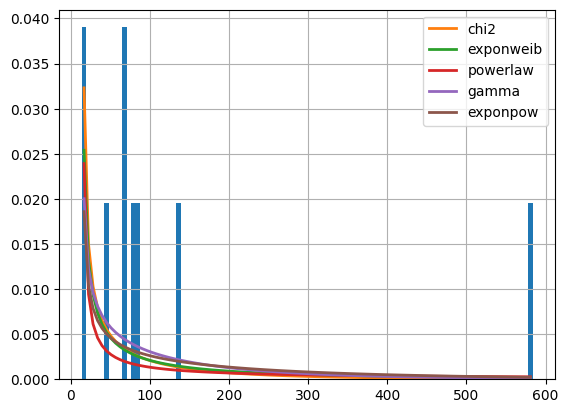

In [12]:
from fitter import Fitter, get_common_distributions


#Organize Data - from question
SR_y = pd.Series(one_pr, name="one_pr (Target Vector Distribution)")


# fitter
distributions_set = get_common_distributions()
distributions_set.extend(['arcsine', 'cosine', 'expon', 'weibull_max', 'weibull_min', 
                          'dweibull', 't', 'pareto', 'exponnorm', 'lognorm',
                          "norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"])  

f = Fitter(SR_y, distributions = distributions_set) 
f.fit()
f.summary()

In [13]:
f.fitted_param

{'expon': (14.176470588235293, 108.05124309017756),
 'norm': (122.22771367841285, 166.75441998267377),
 'powerlaw': (0.15375590663320893, 14.176470588235292, 569.4399677679293),
 'cauchy': (69.16099786884135, 23.50585075978166),
 'rayleigh': (-102.80084958420868, 198.04657390093573),
 'lognorm': (1.579252863039548, 12.422027511987107, 41.861544886914714),
 'uniform': (14.176470588235293, 569.4399677679291),
 'gamma': (0.5834428147085788, 14.176470588235292, 181.7073340143167),
 'chi2': (0.6542016164316801, 14.176470588235292, 92.57153775503738),
 'cosine': (67.549683744172, 30.404348516612657),
 'arcsine': (-42.68661907725996, 626.3030574334244),
 'weibull_max': (0.15638779261414593, 583.6164383561645, 1.726984045520405),
 'pareto': (1.920939648529594, -93.73373504348791, 107.9102056317232),
 'dweibull': (0.6079873903251471, 77.58333333333334, 125.34619181239358),
 'weibull_min': (0.5141051976066084, 14.176470588235292, 170.31269631562725),
 'exponnorm': (2157.335017247492, 14.02119838

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


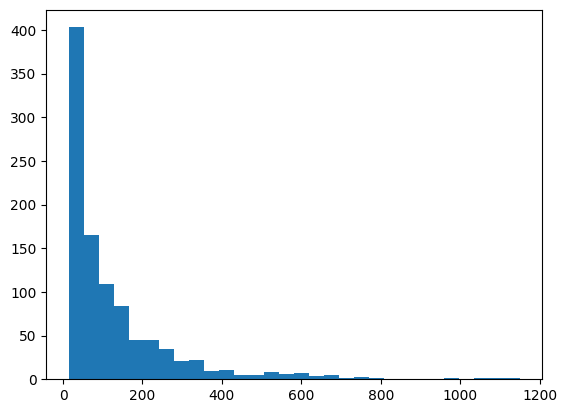

In [14]:
from scipy.stats import gamma

r = gamma.rvs(0.5834428147085788, 14.176470588235292, 181.7073340143167, size=1000)

abs_r = []

for i in r:
    if i >= 0:
        abs_r.append(i)
    if i < 0:
        abs_r.append(0)
        
plt.hist(abs_r, bins=30, histtype="stepfilled")
#plt.set_xlim([x[0], x[-1]])
plt.legend(loc='best', frameon=False)
plt.show()

((array([-3.19758950e+00, -2.93237785e+00, -2.78437841e+00, -2.67999560e+00,
         -2.59855946e+00, -2.53139899e+00, -2.47402263e+00, -2.42379214e+00,
         -2.37902149e+00, -2.33856546e+00, -2.30160949e+00, -2.26755284e+00,
         -2.23593934e+00, -2.20641415e+00, -2.17869564e+00, -2.15255643e+00,
         -2.12781017e+00, -2.10430217e+00, -2.08190261e+00, -2.06050135e+00,
         -2.04000420e+00, -2.02032992e+00, -2.00140792e+00, -1.98317650e+00,
         -1.96558137e+00, -1.94857451e+00, -1.93211325e+00, -1.91615948e+00,
         -1.90067901e+00, -1.88564107e+00, -1.87101783e+00, -1.85678408e+00,
         -1.84291686e+00, -1.82939524e+00, -1.81620005e+00, -1.80331371e+00,
         -1.79072004e+00, -1.77840415e+00, -1.76635224e+00, -1.75455157e+00,
         -1.74299028e+00, -1.73165738e+00, -1.72054262e+00, -1.70963644e+00,
         -1.69892989e+00, -1.68841463e+00, -1.67808281e+00, -1.66792707e+00,
         -1.65794051e+00, -1.64811661e+00, -1.63844924e+00, -1.62893261e+00,

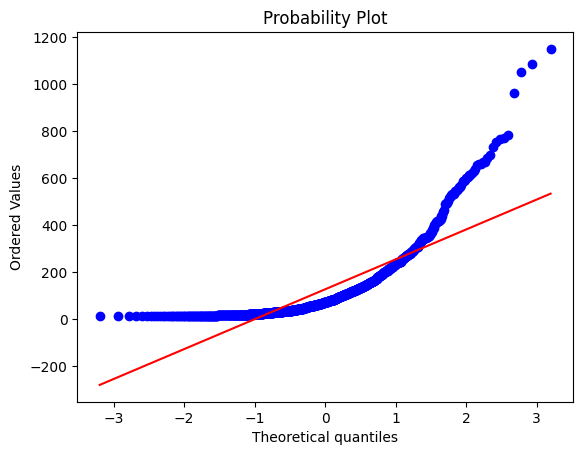

In [15]:
stats.probplot(abs_r, plot=plt)

# All years

In [16]:
claims = {}
for t in tqdm(years):
    claims_t = []
    for i in range(10000):
        rvs = poisson.rvs(49.0*t)*gamma.rvs(0.5834428147085788, 14.176470588235292, 181.7073340143167)
        if rvs >= 0:
            claims_t.append(rvs)
        if rvs < 0:
            claims_t.append(0)
        claims[f'X_{t}'] = claims_t

100%|███████████████████████████████████████████| 61/61 [00:30<00:00,  2.02it/s]


In [17]:
sorted_claims = {k: sorted(v) for k, v in claims.items()}

In [18]:
cdf_all = pd.DataFrame(sorted_claims)
cdf_all

,X_0.0,X_0.08333333333333333,X_0.16666666666666666,X_0.25,X_0.3333333333333333,X_0.4166666666666667,X_0.5,X_0.5833333333333334,X_0.6666666666666666,X_0.75,...,X_4.25,X_4.333333333333333,X_4.416666666666667,X_4.5,X_4.583333333333333,X_4.666666666666667,X_4.75,X_4.833333333333333,X_4.916666666666667,X_5.0
0,0.0,0.000000,0.000000,42.807420,71.300572,95.315245,146.837932,156.374048,242.297133,259.907941,...,2466.987945,2397.748210,2534.773072,2552.545397,2546.619501,2618.545069,2525.810789,2898.155592,2757.936958,2794.376490
1,0.0,0.000000,0.000000,55.409714,73.338385,101.867624,187.109202,209.214267,249.921556,296.755003,...,2495.118873,2506.809604,2589.297217,2567.802300,2667.049111,2740.689085,2610.498291,2920.088253,2807.022118,2841.998113
2,0.0,0.000000,0.000000,57.704895,77.045224,113.507136,189.324147,213.291046,269.447910,302.895409,...,2500.391256,2527.541360,2598.576241,2610.839061,2680.508322,2783.983969,2764.556049,2932.031226,2846.950574,2908.877523
3,0.0,0.000000,0.000000,58.199942,86.805330,129.536220,194.086634,218.068380,276.167609,315.937491,...,2519.837666,2535.848049,2651.505145,2656.487292,2695.567772,2802.960198,2786.545130,2942.834948,2851.945771,3004.321945
4,0.0,0.000000,0.000000,60.843052,88.667958,144.675446,194.128437,236.607160,284.683743,317.422282,...,2541.923478,2541.301546,2661.577943,2686.640405,2696.766914,2805.334451,2821.403976,2960.539926,2923.394530,3017.943710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,5761.797617,12397.079136,15836.660781,22226.016777,24838.671851,31372.504101,33142.659497,43333.490420,44114.956308,...,233209.537365,248954.118718,264692.856913,255890.426942,264304.150730,282537.466128,266423.731737,264969.858907,280052.930684,281577.026220
9996,0.0,5892.394695,12684.068234,16216.758688,25384.393967,24872.907316,32581.996017,33616.836262,44542.502544,48005.833624,...,237036.963471,266517.838662,272500.562570,263973.174504,280249.926812,292914.147719,283305.242241,273649.734341,280738.754149,285316.529576
9997,0.0,6444.117231,12894.378595,18449.847058,25889.932724,25269.090375,35346.475020,33798.065480,45469.578179,50499.447449,...,265292.667987,292647.891929,283507.198145,264991.453869,286471.126591,294764.143979,283350.252189,282168.258372,289576.496432,306951.875514
9998,0.0,6855.038396,16571.868067,18967.236677,30032.670884,26663.103913,36376.497305,39034.726070,45771.893831,51665.248832,...,303717.476091,307195.150071,288336.594921,279860.583327,301474.432506,302643.014491,351304.574644,291312.895283,315883.320483,344091.752264


In [19]:
def integrand(x):
    return a

prob = []

for i in range(1,10001):
    prob.append(i/10000)

for i in years:
    cdf_all[f'prob_{i}'] = prob
    
for i in years:
    cdf_all[f'prob_{i}'][(cdf_all[f'X_{i}']==0)] = 0

n= -1
for i in years:
    n+=1
    cdf_all[f'rate_{i}'] = rate[n]

n= -1
for i in years:
    n+=1
    a = rate[n]
    cdf_all[f'discount_{i}'] = math.exp(-quad(integrand, 0, i)[0])

for i in years:
    cdf_all[f'V_{i}'] = cdf_all[f'discount_{i}']*cdf_all[f'prob_{i}']

/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_98261/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf_all[f'rate_{i}'] = rate[n]
/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_98261/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf_all[f'rate_{i}'] = rate[n]
/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_98261/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [20]:
X_0 = []
Y_0 = []
Z_0 = []

for i in years:
    for n in cdf_all[f'X_{i}'].tolist():
        X_0.append(n)

for i in years:
    for n in cdf_all[f'V_{i}'].tolist():
        Y_0.append(n)

for i in years:
    for n in range(10000):
        Z_0.append(i)


X = X_0
Y = Y_0
Z = Z_0

plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),10),np.linspace(np.min(Y),np.max(Y),10))
plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear')


@interact(elev=IntSlider(min=-180, max=180, step=10, value=30, continuous_update=False), azim=IntSlider(min=-180, max=180, step=10, value=30, continuous_update=False))
def plot_3d(elev, azim):
    #Figure settings
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(111, projection='3d')
    #Display 3D graph
    ax.plot_surface(plotx,plotz,ploty,cstride=1,rstride=1,cmap='viridis')
    ax.set_xlabel('D (критический уровень триггера)') 
    ax.set_ylabel('T (срок, лет)') 
    ax.set_zlabel('V (Стоимость) ')
    
    #Set the initial value of the viewing direction of the 3D graph
    ax.view_init(elev=elev, azim=azim)
    plt.show()

interactive(children=(IntSlider(value=30, continuous_update=False, description='elev', max=180, min=-180, step…

In [21]:
# Expected loss 2%
s_2 = round(((1/cdf_all['V_2.0'][9800])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9800])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9800])**(1/4)-1-0.1192)*100, 3)

print('Expected loss 2%')
print(round(cdf_all['X_2.0'][9800], 3), round(cdf_all['X_3.0'][9800], 3), round(cdf_all['X_4.0'][9800], 3))
print(round(cdf_all['V_2.0'][9800], 4), round(cdf_all['V_3.0'][9800], 4), round(cdf_all['V_4.0'][9800], 4))
print(s_2, s_3, s_4)
print()

# Expected loss 2,5%
s_2 = round(((1/cdf_all['V_2.0'][9750])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9750])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9750])**(1/4)-1-0.1192)*100, 3)
print('Expected loss 2,5%')
print(round(cdf_all['X_2.0'][9750], 3), round(cdf_all['X_3.0'][9750], 3), round(cdf_all['X_4.0'][9750], 3))
print(round(cdf_all['V_2.0'][9750], 4), round(cdf_all['V_3.0'][9750], 4), round(cdf_all['V_4.0'][9750], 4))
print(s_2, s_3, s_4)
print()

# Expected loss 3%
s_2 = round(((1/cdf_all['V_2.0'][9700])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9700])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9700])**(1/4)-1-0.1192)*100, 3)
print('Expected loss 3%')
print(round(cdf_all['X_2.0'][9700], 3), round(cdf_all['X_3.0'][9700], 3), round(cdf_all['X_4.0'][9700], 3))
print(round(cdf_all['V_2.0'][9700], 4), round(cdf_all['V_3.0'][9700], 4), round(cdf_all['V_4.0'][9700], 4))
print(s_2, s_3, s_4)

Expected loss 2%
54707.963 80420.998 108392.468
0.7581 0.6672 0.5875
2.3 2.278 2.3

Expected loss 2,5%
51610.063 75322.118 101596.501
0.7542 0.6638 0.5845
2.594 2.474 2.446

Expected loss 3%
47953.0 70448.596 96580.029
0.7504 0.6604 0.5815
2.891 2.67 2.593
